In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

This is a tutorial notebook for using BERT to solve a simple NLI problem. Specifically, given two statements, a premise and a hypothesis, can we predict whether the premise entails the hypothesis, the two are unrelated, or the two are contradictory? 

BERT is a NN architecture which has two broad aims during training: Masked Language Modelling (MLM) and Next Sentence Prediction (NSP). These two are trained simultaneously. The first, MLM, aims to teach the model the language itself. This works by masking certain words in the input and training the model to be able to "fill in the blanks", i.e. to be able to understand the language to the point where it can complete a sentence with missing words. NSP trains the model to determine whether two sentences are related in some way (the precise relation depends on the problem that is being solved), i.e. it learns to understand context. Here, we will use a simple implementation of a base pretrained model and will not tune any of the parameters. 

This notebook is based on the tutorial notebook https://www.kaggle.com/anasofiauzsoy/tutorial-notebook/notebook, with some small changes and additions. 

In [3]:
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf

2022-03-14 22:07:45.559657: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-03-14 22:07:45.559781: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Let's set up our TPU.

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

2022-03-14 22:07:50.322381: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-14 22:07:50.325489: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-03-14 22:07:50.325525: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-14 22:07:50.325553: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cdfda5561e0f): /proc/driver/nvidia/version does not exist
2022-03-14 22:07:50.327926: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

## Downloading Data

The training set contains a premise, a hypothesis, a label (0 = entailment, 1 = neutral, 2 = contradiction), and the language of the text.

In [5]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")

Let's take a quick look at the data:

In [6]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


Let's look at one of the pairs of sentences.

In [7]:
train.premise.values[1]

'These are issues that we wrestle with in practice groups of law firms, she said. '

In [8]:
train.hypothesis.values[1]

'Practice groups are not permitted to work on these issues.'

In [9]:
train.label.values[1]

2

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


No null data, so no need for any imptuation.

In [11]:
train.describe()

,label
count,12120.000000
mean,0.990759
std,0.824523
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


Let's look at the language frequencies:

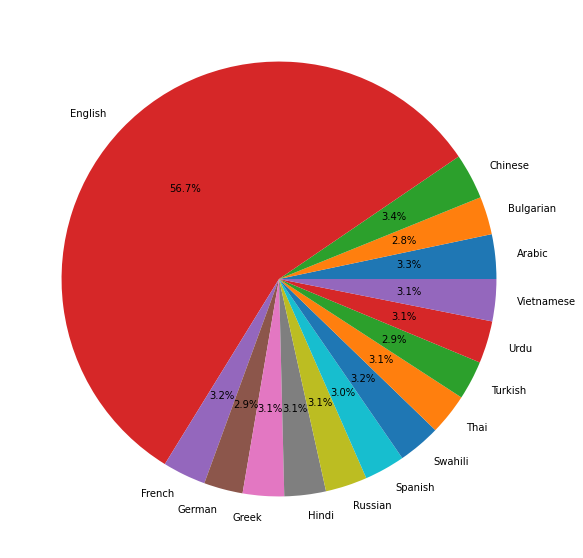

In [12]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

Look at distribution of each label:

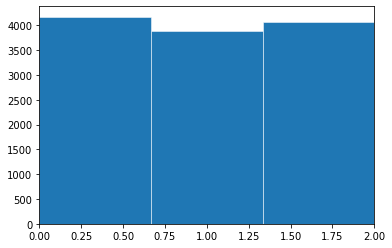

In [13]:
fig, ax = plt.subplots()

ax.hist(train.label, bins=3, linewidth=0.5, edgecolor="white")

ax.set(xlim=(0, 2))

plt.show()

Roughly equal split. Let's see if the same holds when we factor in the language:

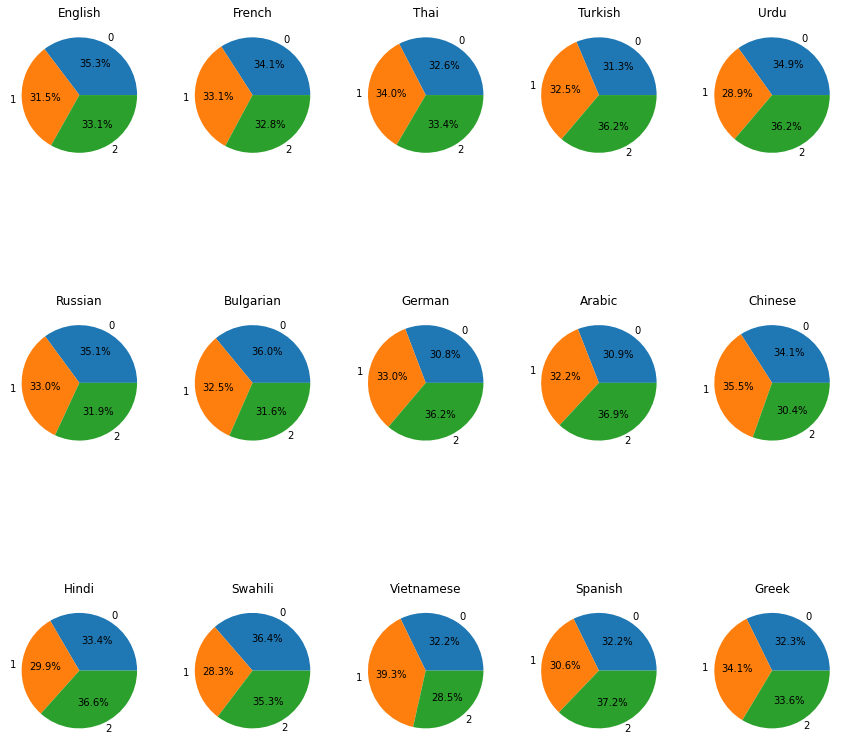

In [14]:
languages = train.language.unique()

fig, ax = plt.subplots(3,5, figsize = (15,15))

for i in range(1,4):
    for j in range(1,6):
        train_1 = train[train["language"]==languages[5*(i-1)+j-1]]
        labels, frequencies = np.unique(train_1.label.values, return_counts = True)
        plt.subplot(3,5,5*(i-1)+j)
        plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
        plt.title(languages[5*(i-1)+j-1])

plt.show()

There is a roughly even split across all labels for all languages. 

## Preparing Data for Input

We'll use the pretrained multilingual BERT model from huggingface.

In [15]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Let's define a function to implement the tokenizer:

In [16]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

Example:

In [17]:
encode_sentence("I love machine learning")

[146, 16138, 21432, 26901, 102]

BERT uses three kind of input data- input word IDs, input masks, and input type IDs.

These allow the model to know that the premise and hypothesis are distinct sentences, and also to ignore any padding from the tokenizer.

We add a [CLS] token to denote the beginning of the inputs, and a [SEP] token to denote the separation between the premise and the hypothesis. We also need to pad all of the inputs to be the same size. For more information about BERT inputs, see: https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel

Now, we're going to encode all of our premise/hypothesis pairs for input into BERT.

In [18]:
def bert_encode(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [19]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [20]:
train_input

{'input_word_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[  101, 10111, 11762, ...,     0,     0,     0],
        [  101, 13252, 10301, ...,     0,     0,     0],
        [  101, 13810, 32181, ...,     0,     0,     0],
        ...,
        [  101, 10117, 12452, ...,     0,     0,     0],
        [  101, 11699, 10105, ...,     0,     0,     0],
        [  101, 11399, 14764, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

## Creating & Training Model

Now, we can incorporate the BERT transformer into a Keras Functional Model. Ideally, we would tune the parameters to better fit our needs, but here we will simply do a basic implementation.

In [21]:
max_len = 259

def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
with strategy.scope():
    model = build_model()
    model.summary()

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 259)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 259)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 259)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

We will only do a couple of epochs here to minimise the training time, but ideally we would test different parameters on a validation set, perhaps using cross-validation with some sort of search method (e.g. sklearn.model_selection.RandomizedSearchCV). 

In [23]:
model.fit(train_input, train.label.values, epochs = 2, verbose = 1, batch_size = 64, validation_split = 0.2)

Epoch 1/2
152/152 [==============================] - 151s 514ms/step - loss: 1.0918 - accuracy: 0.4192 - val_loss: 0.8398 - val_accuracy: 0.6262
Epoch 2/2
152/152 [==============================] - 19s 128ms/step - loss: 0.7952 - accuracy: 0.6495 - val_loss: 0.8066 - val_accuracy: 0.6481


In [24]:
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5195 non-null   object
 1   premise     5195 non-null   object
 2   hypothesis  5195 non-null   object
 3   lang_abv    5195 non-null   object
 4   language    5195 non-null   object
dtypes: object(5)
memory usage: 203.1+ KB


In [26]:
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [27]:
test_input

{'input_word_ids': <tf.Tensor: shape=(5195, 234), dtype=int32, numpy=
 array([[  101,   764, 28744, ...,     0,     0,     0],
        [  101, 13498, 11917, ...,     0,     0,     0],
        [  101, 10131, 24552, ...,     0,     0,     0],
        ...,
        [  101,  3239,  5755, ...,     0,     0,     0],
        [  101, 98370,   112, ...,     0,     0,     0],
        [  101, 10167, 15078, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(5195, 234), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(5195, 234), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, 

The max_length for the test data is less than that for the training data, so let's add the training data and then remove it before we make our predictions:

In [28]:
train2 = train.copy()
train2.pop("label")

df = pd.concat([train2, test])

In [29]:
df.head()

,id,premise,hypothesis,lang_abv,language
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai


In [30]:
df_input = bert_encode(df.premise.values, df.hypothesis.values, tokenizer)
df_input

{'input_word_ids': <tf.Tensor: shape=(17315, 259), dtype=int32, numpy=
 array([[  101, 10111, 11762, ...,     0,     0,     0],
        [  101, 13252, 10301, ...,     0,     0,     0],
        [  101, 13810, 32181, ...,     0,     0,     0],
        ...,
        [  101,  3239,  5755, ...,     0,     0,     0],
        [  101, 98370,   112, ...,     0,     0,     0],
        [  101, 10167, 15078, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(17315, 259), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(17315, 259), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

Now let's define our test input:

In [31]:
test_input["input_word_ids"] = df_input["input_word_ids"][12120:]
test_input["input_mask"] = df_input["input_mask"][12120:]
test_input["input_type_ids"] = df_input["input_type_ids"][12120:]

In [32]:
test_input

{'input_word_ids': <tf.Tensor: shape=(5195, 259), dtype=int32, numpy=
 array([[  101,   764, 28744, ...,     0,     0,     0],
        [  101, 13498, 11917, ...,     0,     0,     0],
        [  101, 10131, 24552, ...,     0,     0,     0],
        ...,
        [  101,  3239,  5755, ...,     0,     0,     0],
        [  101, 98370,   112, ...,     0,     0,     0],
        [  101, 10167, 15078, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(5195, 259), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(5195, 259), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, 

## Generating & Submitting Predictions

In [33]:
predictions = [np.argmax(i) for i in model.predict(test_input)]

The submission file will consist of the ID column and a prediction column. We can just copy the ID column from the test file, make it a dataframe, and then add our prediction column.

In [34]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

In [35]:
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,2


In [36]:
submission.to_csv("submission.csv", index = False)